# OSM POIs

Points of Interests from OpenStreetMap data.

In [16]:
import requests
import json
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import os

from shapely.geometry import Point, LineString
from adjustText import adjust_text

overpass_url = "http://overpass-api.de/api/interpreter"


In [17]:
def geojsnify(a):
    returnable = {
        "type": "FeatureCollection",
        "features": []
    }
    for element in a:
        if element['type'] == 'way':
            coords = [(geom['lon'], geom['lat']) for geom in element['geometry']]
            line = LineString(coords)
            feature = {'type': 'Feature', 'geometry': line.__geo_interface__, 'properties': {'type': element['type']}}
            returnable["features"].append(feature)
        elif element['type'] == 'node':
            point = Point(element['lon'], element['lat'])
            feature = {'type': 'Feature', 'geometry': point.__geo_interface__, 'properties': {'type': element['type']}}
            returnable["features"].append(feature)
        elif element['type'] == 'LineString':
            coords = [(geom['lon'], geom['lat']) for geom in element['geometry']]
            line = LineString(coords)
            feature = {'type': 'Feature', 'geometry': line.__geo_interface__, 'properties': {'type': element['type']}}
            returnable["features"].append(feature)
    return returnable

# Cities

In [18]:

cities_query = """
[out:json];
area["ISO3166-1"="FI"][admin_level=2];
node[place~"city|town"](area);
out center;
"""

cities_response = requests.get(overpass_url, params={"data": cities_query})
cities_data = cities_response.json()

In [19]:
finland_query = """
[out:json];
rel[boundary=administrative][admin_level=2]["ISO3166-1"="FI"];
out geom;
"""

finland_response = requests.get(overpass_url, params={"data": finland_query})
finland_data = finland_response.json()
print(finland_data)

{'version': 0.6, 'generator': 'Overpass API 0.7.61.5 4133829e', 'osm3s': {'timestamp_osm_base': '2024-03-04T18:29:00Z', 'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'}, 'elements': [{'type': 'relation', 'id': 54224, 'bounds': {'minlat': 59.4541578, 'minlon': 19.0832, 'maxlat': 70.0922939, 'maxlon': 31.5867071}, 'members': [{'type': 'node', 'ref': 1372477580, 'role': 'admin_centre', 'lat': 60.1674881, 'lon': 24.9427473}, {'type': 'node', 'ref': 432424981, 'role': 'label', 'lat': 63.2467777, 'lon': 25.9209164}, {'type': 'way', 'ref': 187629647, 'role': 'outer', 'geometry': [{'lat': 65.1274068, 'lon': 24.099536}, {'lat': 65.1118905, 'lon': 24.0943866}, {'lat': 65.0801661, 'lon': 24.0838675}, {'lat': 65.0575011, 'lon': 24.0697221}, {'lat': 65.0253865, 'lon': 24.0496998}, {'lat': 65.008124, 'lon': 24.0385202}]}, {'type': 'way', 'ref': 187629645, 'role': 'outer', 'geometry': [{'lat': 65.008124, 'lon': 24.0385202}, {'lat

In [20]:

finland_bounds = finland_data["elements"][0]["bounds"]
aspect_ratio = 1 + (finland_bounds['maxlat'] - finland_bounds['minlat']) / (finland_bounds['maxlon'] - finland_bounds['minlon'])
print(aspect_ratio)



1.8508121773290314


In [21]:
gdf_finland = gpd.read_file("data/wind/finland.geojson")
# fig, ax = plt.subplots(figsize=(10, 10 * aspect_ratio))
# gdf_finland.plot(ax=ax, color='blue')
# ax.set_aspect(aspect_ratio)
# plt.show()

In [22]:
#print(json.dumps(data, indent=2))
cities = [(element["tags"]["name"], int(re.sub(r'\D', '', str(element["tags"].get("population", 0)))), element["lat"], element["lon"]) for element in cities_data["elements"]]
print(type(cities))
cities = list(filter(lambda x: x[1] > 1000, cities))
print(cities)
cities = sorted(cities, key = lambda x: -x[1])
print(cities)

<class 'list'>
[('Pori', 83697, 61.4865443, 21.7968859), ('Harjavalta', 7513, 61.3125216, 22.1357413), ('Luvia', 3359, 61.3601139, 21.6267263), ('Turku', 194483, 60.4517531, 22.2670522), ('Porvoo', 50667, 60.3953913, 25.6604862), ('Kauniainen', 8506, 60.2098563, 24.7294936), ('Espoo', 293333, 60.2047672, 24.6568435), ('Kangasniemi', 5801, 61.9895047, 26.6440817), ('Vörå', 6720, 63.1304959, 22.250699), ('Kankaanpää', 12760, 61.8027147, 22.3965338), ('Karvia', 2555, 62.1373063, 22.5603265), ('Oulu', 207513, 65.0118734, 25.4716809), ('Koria', 4050, 60.8454623, 26.6029463), ('Veikkola', 5391, 60.2693626, 24.4426969), ('Pieksämäki', 17367, 62.300466, 27.1639512), ('Kirkkonummi', 40130, 60.1227857, 24.4406694), ('Vantaa', 237632, 60.2921321, 25.0411832), ('Tampere', 241708, 61.4980214, 23.7603118), ('Kuopio', 120252, 62.8924601, 27.6781839), ('Lahti', 120161, 60.9826014, 25.6613764), ('Hyvinkää', 46616, 60.6335719, 24.8695328), ('Imatra', 26039, 61.1923342, 28.7716996), ('Jakobstad', 19077, 

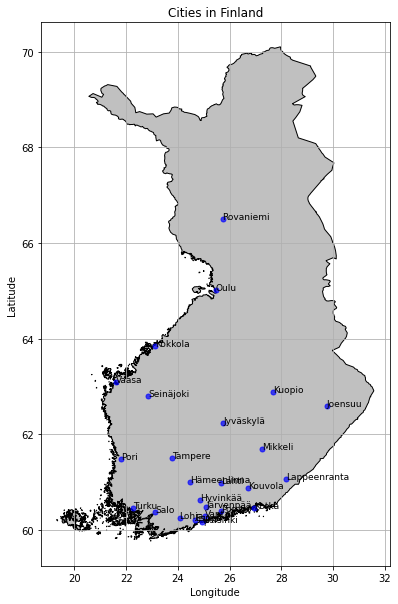

In [23]:
latitudes = [i[2] for i in cities]
longitudes = [i[3] for i in cities]
populations = [i[1] for i in cities]


fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')


#ax.scatter(longitudes, latitudes, alpha=0.5, color='blue')  # Adjust the color as needed

for i in cities[:25]:
    ax.plot(i[3], i[2], color='blue', marker='o', markersize=5, alpha=0.7)
    ax.text(i[3], i[2], i[0], fontsize=9)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Cities in Finland')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()

# High voltage power lines in Finland



In [24]:

powerlines_query = """
[out:json];
area["ISO3166-1"="FI"][admin_level=2];
(
  way[power=line](area);
  way[power=cable](area);
);
out geom;
"""

powerlines_response = requests.get(overpass_url, params={"data": powerlines_query})
powerline_data = powerlines_response.json()
print(powerline_data)

powerlines_geojson = geojsnify(powerline_data["elements"])

{'version': 0.6, 'generator': 'Overpass API 0.7.61.5 4133829e', 'osm3s': {'timestamp_osm_base': '2024-03-04T18:29:00Z', 'timestamp_areas_base': '2024-03-04T13:21:13Z', 'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'}, 'elements': [{'type': 'way', 'id': 5031651, 'bounds': {'minlat': 61.3187435, 'minlon': 24.0259136, 'maxlat': 61.3630494, 'maxlon': 24.2483711}, 'nodes': [9675572383, 9675572384, 1710214738, 9675572385, 1710214751, 9675572386, 33617426, 1710214757, 1710214754, 1710214746, 1710214735, 9891256800, 33617425, 33617424, 1710214731, 1710214728, 1710214709, 33617423, 1710214696, 1710214694, 1710214688, 33617422, 1710214681, 33617421, 33617420, 1710214662, 33617419, 1710214637, 1710214627, 1710214618, 33617418, 1710214603, 33617417, 1710214601, 1710214602, 1710214604, 1710214610, 33617415, 1710214622, 1710214625, 33617414, 1710214619, 1710214616, 33617413, 33617412, 1651439670, 33617410, 1651439679, 33617409, 

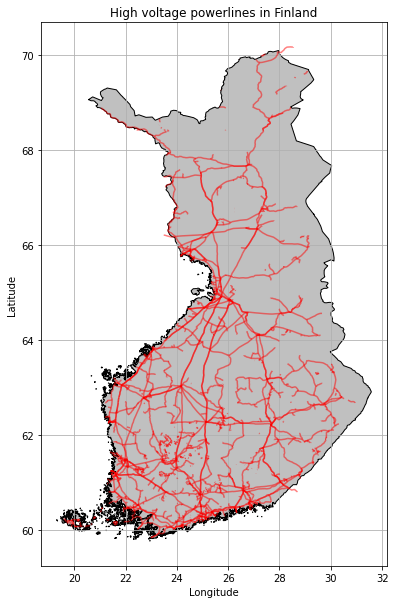

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')

powerline_gdp = gpd.GeoDataFrame.from_features(powerlines_geojson)
powerline_gdp.plot(ax=ax, color='red', alpha=0.5)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('High voltage powerlines in Finland')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()

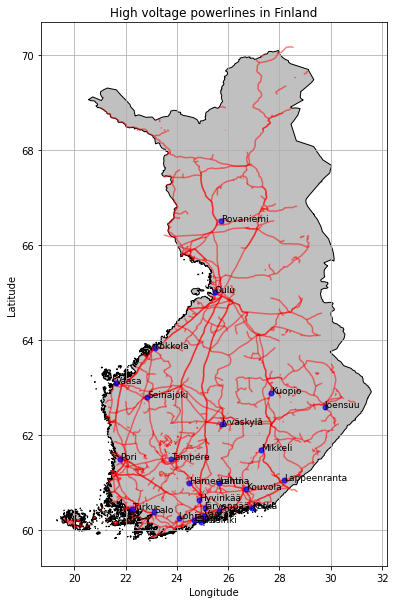

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')

powerline_gdp = gpd.GeoDataFrame.from_features(powerlines_geojson)
powerline_gdp.plot(ax=ax, color='red', alpha=0.5)  # Adjust color and transparency as needed

for i in cities[:25]:
    ax.plot(i[3], i[2], color='blue', marker='o', markersize=5, alpha=0.7)
    ax.text(i[3], i[2], i[0], fontsize=9)
    
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('High voltage powerlines in Finland')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()

## Subsea cable locations

Not very detailed, probably not interesting.

In [27]:
subseacable_query = """
[out:json];
area["ISO3166-1"="FI"][admin_level=2];
(
  way["seamark:cable_submarine:category"=fibre_optic](area);
);
out geom;
"""

subseacable_response = requests.get(overpass_url, params={"data": subseacable_query})
subseacable_data = subseacable_response.json()
print(subseacable_data)

subseacable_geojson = geojsnify(subseacable_data["elements"])

{'version': 0.6, 'generator': 'Overpass API 0.7.61.5 4133829e', 'osm3s': {'timestamp_osm_base': '2024-03-04T18:29:00Z', 'timestamp_areas_base': '2024-03-04T13:21:13Z', 'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'}, 'elements': [{'type': 'way', 'id': 174097208, 'bounds': {'minlat': 59.8450411, 'minlon': 26.8215109, 'maxlat': 60.4167859, 'maxlon': 28.5658946}, 'nodes': [1848363960, 1848363958, 1848363956, 1848363954, 1848363951, 1848363950, 1848363948, 1848363947, 1848363945, 1848363943, 1848363942, 1848363940, 1848363939, 1848363937, 1848363936, 1848363935, 1848363932, 1848363930, 1848363929, 1848363927, 1848363925, 1848363923, 1848363922, 1848363921, 1848363920, 1848363919, 1848363918, 1848363917, 1848363914, 1848363807, 1848363799, 1848363764, 1848363709, 1848363511, 1848363383, 1848363408, 1848363546, 1848363484, 1848363280, 1848363275, 1848363242, 1848363238], 'geometry': [{'lat': 60.4167859, 'lon': 26.909581

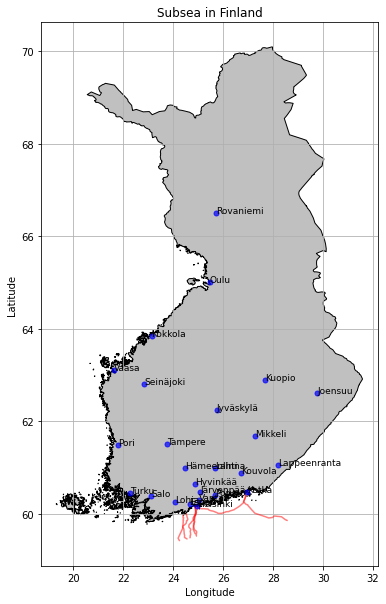

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_finland.plot(ax=ax, color='silver', edgecolor='black')

subseacable_gdp = gpd.GeoDataFrame.from_features(subseacable_geojson)
subseacable_gdp.plot(ax=ax, color='red', alpha=0.5)

for i in cities[:25]:
    ax.plot(i[3], i[2], color='blue', marker='o', markersize=5, alpha=0.7)
    ax.text(i[3], i[2], i[0], fontsize=9)
    
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Subsea in Finland')
ax.grid(True)
ax.set_aspect(aspect_ratio)
plt.show()

# Conclusion

All atleast mildly useful data in one plot.

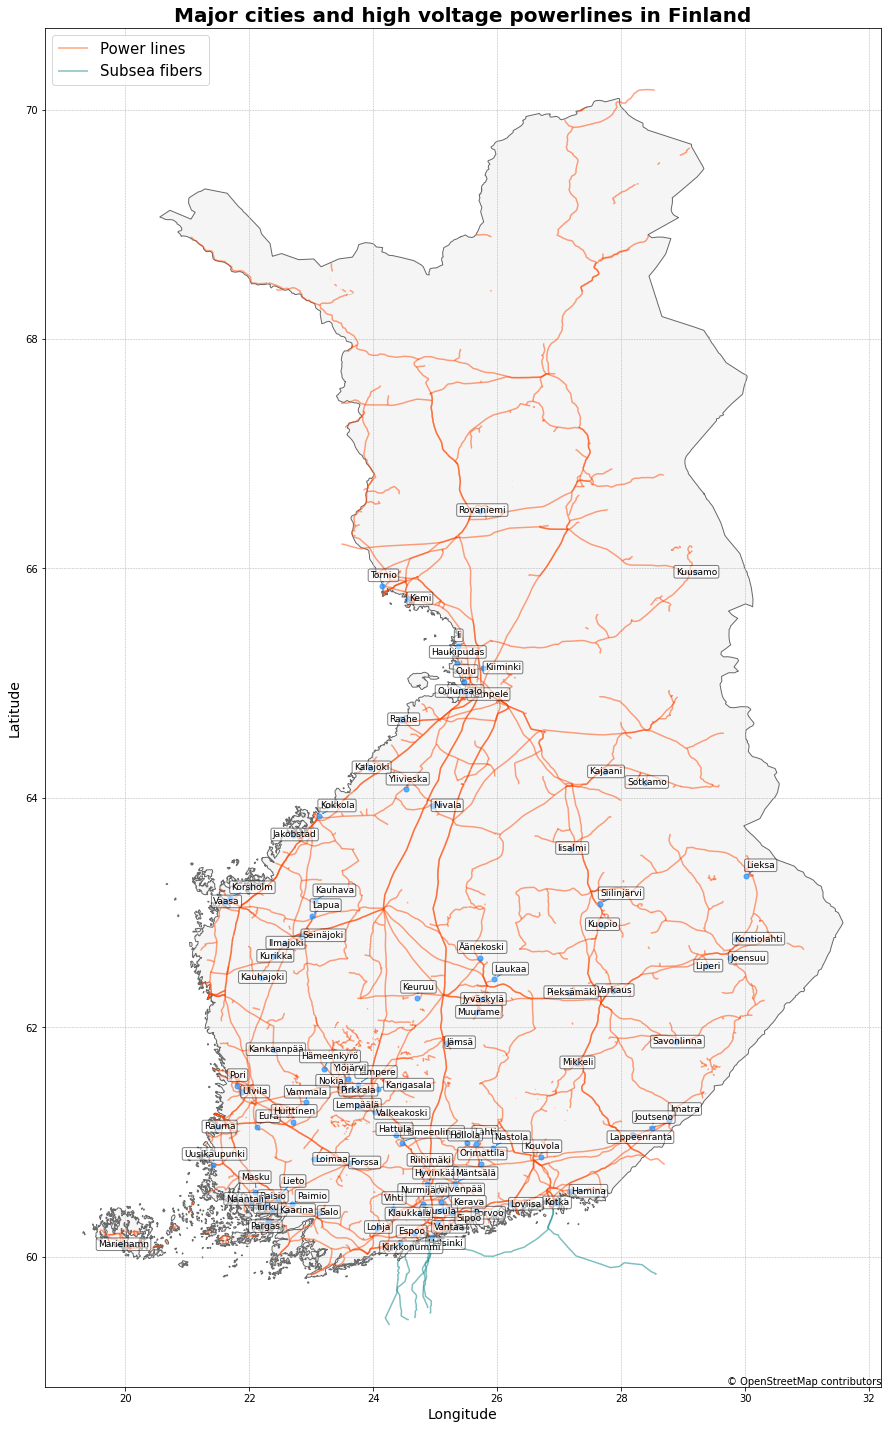

In [39]:
fig, ax = plt.subplots(figsize=(25, 25))
gdf_finland.plot(ax=ax, color='whitesmoke', edgecolor='dimgray')

powerline_gdp = gpd.GeoDataFrame.from_features(powerlines_geojson)
powerline_gdp.plot(ax=ax, color='orangered', alpha=0.5, label="Power lines")

subseacable_gdp = gpd.GeoDataFrame.from_features(subseacable_geojson)
subseacable_gdp.plot(ax=ax, color='teal', alpha=0.5, label="Subsea fibers")

texts = []
for i in cities[:100]:
    ax.plot(i[3], i[2], color='dodgerblue', marker='o', markersize=5, alpha=0.7)
    texts.append(ax.text(i[3] + 0.01, i[2] + 0.01, i[0], fontsize=9, 
                         ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.2')))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='dodgerblue'), force_text=(0.3, 0.3))

ax.set_title('Major cities and high voltage powerlines in Finland', fontsize=20, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_aspect(aspect_ratio)

ax.annotate('\xa9 OpenStreetMap contributors', xy=(1, 0),xycoords='axes fraction', fontsize=10, horizontalalignment='right', verticalalignment='bottom')
ax.legend(loc='upper left', fontsize=15)

plt.show()